In [125]:
#Import Library required later in image processing
import os
import copy
import cv2
import imutils
import numpy as np
import joblib
import matplotlib.pyplot as plt
import ipywidgets as widgets

import random as rng
import argparse

from ipywidgets import interact, interactive, fixed, interact_manual

import os
cwd = os.getcwd()

import IPython

import PIL


def showing(a):
    #b = cv2.cvtColor(a, cv2.COLOR_BGR2RGB) # redundent as images can be loaded as rgb using opencv by simple numpy trick ie: [:,:,::-1]
    IPython.display.display(PIL.Image.fromarray(a))

#### Load Image(s) interactively

In [121]:
#Load multiple/single image to be porcessed later in the workflow
uploader = widgets.FileUpload(
    accept='',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)
uploader

FileUpload(value={}, description='Upload', multiple=True)

#### Scroll through Images

In [126]:
#Display Image
def img_scroll(ind_num):
    global img
    Image_index_num=list(uploader.value)
    uploaded_file = uploader.value[Image_index_num[ind_num]]
    #Display image using ipywidgets
    img = cv2.imdecode(np.frombuffer(uploaded_file['content'], np.uint8), -1)[:,:,::-1]
    return widgets.Image(value=uploaded_file['content']) #content contains images data in bytes type

interact(img_scroll, ind_num=widgets.IntSlider(min=0, max=len(uploader.value)-1, step=1, value=0));
#Becareful when loading image in RGB or BGR

#output --> img

interactive(children=(IntSlider(value=0, description='ind_num', max=0), Output()), _dom_classes=('widget-inter…

#### Define ROI For Region Specific Image Processing

In [87]:
'''Function used to define ROI by drawing polygon and creating mask'''
#To do
#1. Add saving ROI function and later read back
#2. Add draw rectangle 
#3. Add draw circle
#4. multiple Roi (might have to change saving structure to json format)


#img = src # image source
pts = [] # Initilize for storing points
pts_roi = [[0, 0], [img.shape[1], 0], [img.shape[1], img.shape[0]], [0, img.shape[0]]] # used to mask src image
pts_roi_np = [] # used as generic contour format saving after threshold
clr_prset_cord = True
#######################################################################################
#Input <--img

# :mouse callback function
def draw_roi(event, x, y, flags, param):
    img2 = img.copy()
    global clr_prset_cord
    global pts_roi
     
    if event == cv2.EVENT_LBUTTONDOWN: # Left click, select point
            if clr_prset_cord:
                pts_roi = []
                clr_prset_cord = False
            pts.append((x, y))
            pts_roi.append([x, y])


    if event == cv2.EVENT_RBUTTONDOWN: # Right click to cancel the last selected point
            pts.pop()
            pts_roi = pts_roi[:-1]
 
    if event == cv2.EVENT_MBUTTONDOWN: # 
            mask = np.zeros(img.shape, np.uint8)
            points = np.array(pts, np.int32)
            points = points.reshape((-1, 1, 2))
                     # 
            mask = cv2.polylines(mask, [points], True, (255, 255, 255), 2)
            Mask2 = cv2.fillPoly(mask.copy(), [points], (255, 255, 255)) # for ROI
            Mask3 = cv2.fillPoly(mask.copy(), [points], (0, 255, 0)) # for displaying images on the desktop

            show_image = cv2.addWeighted(src1=img, alpha=0.8, src2=mask3, beta=0.2, gamma=0)

            cv2.imshow("mask", mask2)
            cv2.imshow("show_img", show_image)

            ROI = cv2.bitwise_and(mask2, img)
            cv2.imshow("ROI", ROI)
            cv2.waitKey(0)
 
    if len(pts) > 0:
        # Draw the last point in pts
        cv2.circle(img2, pts[-1], 3, (0, 0, 255), -1)
 
    if len(pts) > 1:
                 # 
        for i in range(len(pts) - 1):
            cv2.circle(img2, pts[i], 5, (0, 0, 255), -1) # x ,y is the coordinates of the mouse click place
            cv2.line(img=img2, pt1=pts[i], pt2=pts[i + 1], color=(255, 0, 0), thickness=2)
 
    cv2.imshow('Draw ROI', img2)
 
 
#Create images and windows and bind windows to callback functions
cv2.namedWindow('Draw ROI')
cv2.setMouseCallback('Draw ROI', draw_roi)
print("[INFO] Click the left button: select the point, right click: delete the last selected point, click the middle button: determine the ROI area")
print("[INFO] Press ‘S’ without clicking anywhere to select whole image as ROI")
print("[INFO] Press ‘S’ to determine the selection area and save it")
print("[INFO] Press ESC to quit")
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:
        break
    if key == ord("s"):
        #add starting coordinate to end to create enclosed polygon
        if pts: #check if list is empty first
            pts.append(pts[0]) 
        #save in dictionary format / multiple roi to add later(still in development phase)
        saved_data = {
            "ROI": pts_roi
        }
        # standard way of saving contour in opencv as points in list
        pts_roi_np = np.array([[pts_roi]])
        #old way of saving ply file
        #joblib.dump(value=saved_data, filename=r'C:\Users\MARVIN\Desktop\opencvtest\roi.pkl')
        
        #want to save polygon as txt file for now.(easy to modify)
        #to scale up the project better to save as json
        with open(cwd+'\\roi.txt','w') as data:
            data.write(str(saved_data))
        print("[INFO] ROI coordinates have been saved to local.")
        break

#output --> pts_roi_np(contour)
##############################################################################
#Input <--img
#Input <--pts_roi_np(contour)

masked_image = copy.deepcopy(img)

#create dummy black image with same size and shape
roi_image = np.zeros( (masked_image.shape[0],masked_image.shape[1],masked_image.shape[2]),dtype = np.uint8)
#to try
# create empty image with same shape as that of src image
#red_img = np.zeros(src.shape)


#fill ROI
#thickness -1 means fill the ROI. can be changed to any interger changes thickness
roi_image = cv2.drawContours(roi_image, pts_roi_np, contourIdx=-1, color=(255,255,255),thickness=-1)

#bitwise and operation to dispay only ROI and future processing
masked_image = cv2.bitwise_and(img, roi_image)#,mask = RoiImage , use or operater to inverse image roi selection


cv2.imshow("Masked Image", masked_image)
cv2.waitKey()
cv2.destroyAllWindows()


#output is an image only sreened for ROI
#output --> masked_image
#output --> roi_image
#Display image 
####################################################################################


[INFO] Click the left button: select the point, right click: delete the last selected point, click the middle button: determine the ROI area
[INFO] Press ‘S’ without clicking anywhere to select whole image as ROI
[INFO] Press ‘S’ to determine the selection area and save it
[INFO] Press ESC to quit
[INFO] ROI coordinates have been saved to local.


#### Threshold Image Interactively 

In [94]:
#Interactive threshold image
#Input <--masked_image

max_value = 255
max_type = 4
max_binary_value = 255
trackbar_type = 'Type: \n 0: Binary \n 1: Binary Inverted \n 2: Truncate \n 3: To Zero \n 4: To Zero Inverted'
trackbar_value = 'Value'
window_name = 'Threshold Demo'
def Threshold_Demo(val):
    global binary_thrshld_image
    #0: Binary
    #1: Binary Inverted
    #2: Threshold Truncated
    #3: Threshold to Zero
    #4: Threshold to Zero Inverted
    threshold_type = cv2.getTrackbarPos(trackbar_type, window_name)
    threshold_value = cv2.getTrackbarPos(trackbar_value, window_name)
    _, binary_thrshld_image = cv2.threshold(src_gray, threshold_value, max_binary_value, threshold_type )
    cv2.imshow(window_name, binary_thrshld_image)
#parser = argparse.ArgumentParser(description='Code for Basic Thresholding Operations tutorial.')
#parser.add_argument('--input', help='Path to input image.', default='stuff.jpg')
#args = parser.parse_args()
#src = cv.imread(cv.samples.findFile(args.input))

# Convert the image to Gray
src_gray = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
cv2.namedWindow(window_name)
cv2.createTrackbar(trackbar_type, window_name , 3, max_type, Threshold_Demo)
# Create Trackbar to choose Threshold value
cv2.createTrackbar(trackbar_value, window_name , 0, max_value, Threshold_Demo)
# Call the function to initialize
Threshold_Demo(0)
# Wait until user finishes program
# if cv2.waitKey(10) & 0xFF == 27:
#     cv2.destroyAllWindows()

# # #Display image if required
while True:
    Threshold_Demo(0)
    if cv2.waitKey(10) & 0xFF == 27:
        break
cv2.destroyAllWindows()

#output --> binary_thrshld_image

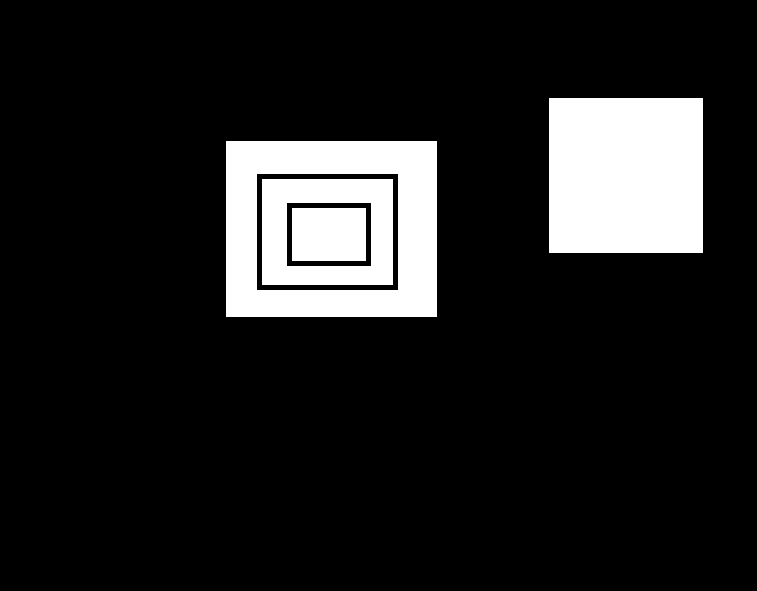

In [58]:
showing(binary_thrshld_image)

#### Create ROI by Thresholding

In [95]:
#Input<--binary_thrshld_image

contours, hierarchy = cv2.findContours(binary_thrshld_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #can to  cv2.CHAIN_APPROX_SIMPLE  if simple rectangle threshold , CHAIN_APPROX_NONE for evry point
#hierarchy is useful when one roi is inside another is is required for further analysis.( potentially helpful)(https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html)
display_contour = cv2.drawContours(copy.copy(img), contours, -1, (0,255,0), 1)

#output--> display_contour,contours

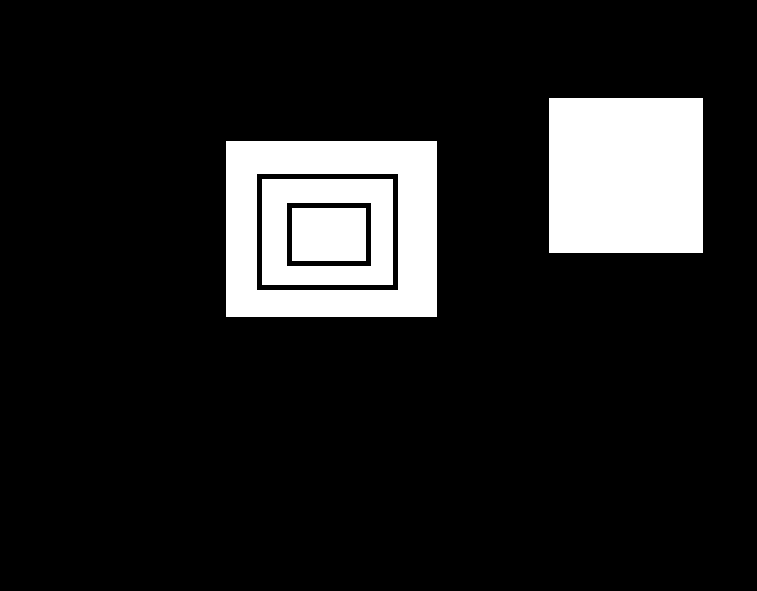

In [128]:
showing(display_contour)

#### Create Enclosing Rectangle

In [102]:
# Approximate contours to polygons + get bounding rects and circles
contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
centers = [None]*len(contours)
radius = [None]*len(contours)
for i, c in enumerate(contours):
    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
    boundRect[i] = cv2.boundingRect(contours_poly[i])
    centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])

In [103]:
# Draw polygonal contour + bonding rects + circles
img_bounding_box_roi = copy.copy(img)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256)) # create random color
    #cv2.drawContours(img_bounding_box_roi, contours_poly, i, color) #draw conturs around roi
    cv2.rectangle(img_bounding_box_roi, (int(boundRect[i][0]), int(boundRect[i][1])),
        (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2) #draw rectangle round roi
    #cv2.circle(img_bounding_box_roi, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2) # draw circle round roi

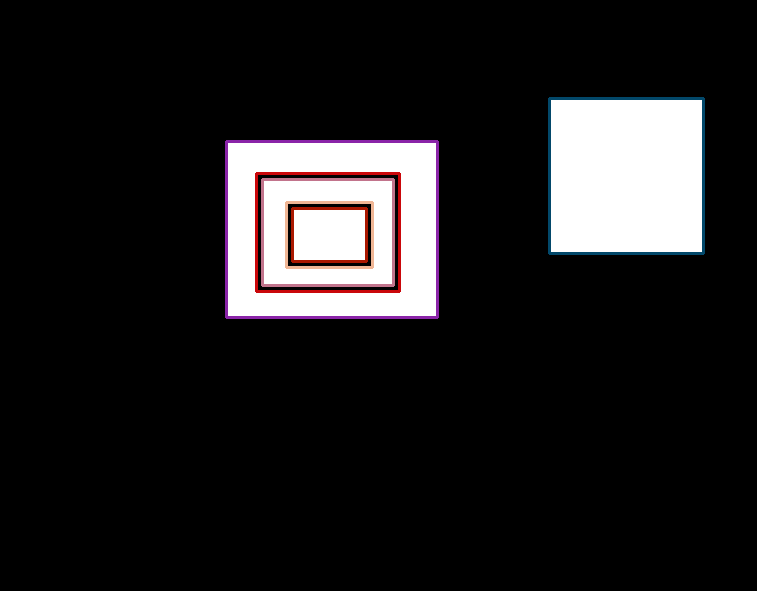

In [104]:
showing(img_bounding_box_roi)

In [106]:
#boundRect[3]

(286, 202, 86, 65)

#### Visual Analysis Tool

In [129]:
%matplotlib widget
plt.imshow(img)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Next Steps

Next step would be to add screen contour using interative widgets .


Add Image Augmentation and operation using UI

Add ROI operation and augmentation